# Solar Output Prediction 
### Writeup + Technical Analysis


### Table of Contents

1. [Introduction](#Introduction)
2. [Executive Summary](#summary)
3. [Gathering Data](#data)
4. [Data Cleaning](#cleaning)
5. [Exploratory Analysis](#eda)
6. [Outliers](#outliers)
7. [Random Forest Model](#random-forest)


<a id='Introduction'></a>
## Introduction

Over the past 10 years, installation costs for solar energy technology have dropped an astonishing 60%¹. This form of renewable energy is more accessible now than ever before. Yet over that same period, soft costs, such as sales and marketing, have remained almost completely stagnant. According to the Solar Energy Industries Association (SEIA), in Q4 2016, soft costs accounted for 67% of installation costs for residential solar². This has moved the impetus for growth in the solar industry from the development of cheaper technologies to a focus on ways to attack soft costs by more efficiently spreading information to potential solar customers.

<img src="http://www.seia.org/sites/default/files/Fig4-SolarPVPriceBreakdown-2017YIR.png" style="width:700px;height:400px;">

## Executive Summary

Our goal with this project is to build a tool that makes information regarding one’s potential for switching to solar available to a wider audience, bringing down the cost of sales and marketing. We accomplished this goal in two stages:
1. Building a machine learning model that predicts the annual energy production of a prospective solar installation.
2. Building a model that predicts installation cost.

### Data

Data for this project came from NREL. The OpenPV Project, which contains data related to over one million solar panel installations across the U.S. This dataset includes the following:
Annual energy production
- Installation cost
- Size
- Orientation
- Tilt
- Installer
- Technology type
- etc.

The OpenPV data was simply downloaded in CSV format from the NREL website, located here: https://openpv.nrel.gov/search

# Data Cleaning

Given that the OpenPV dataset is manually entered data with over one million rows, getting the most out of it required a lot of data cleaning and imputation.

# Exploratory Analysis

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 33

In [3]:
# First let's read in the data.
df = pd.read_csv("./open_pv_clean.csv")
df.head()

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (14,16,17,24,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,level_0,index,state,date_installed,incentive_prog_names,type,size_kw,appraised,zipcode,install_type,installer,cost_per_watt,cost,lbnl_tts,city,utility_clean,tech_1,model1_clean,county,annual_PV_prod,annual_insolation,rebate,sales_tax_cost,tilt1,tracking_type,azimuth1,manufacturer,inv_man_clean,reported_annual_energy_prod,new_constr,tracking,3rdparty,bipv
0,0,0,TX,2013-12-12 00:00:00,Austin Energy,uir,10.560,0.0,78702.0,residential,Advanced Solar & Electric,2.897777,30600.53,1.0,AUSTIN,Austin Energy,Poly,CHSM6610P-240,Travis,14999.831600,5.157692,15000.0,1151.693704,10.0,Fixed,180.0,Chint Solar (Zhejiang),NaN,13836.0,0.0,0.0,0.0,0
1,1,1,TX,2014-07-11 00:00:00,Austin Energy,uir,12.720,0.0,78702.0,residential,Advanced Solar & Electric,3.144654,40000.00,1.0,AUSTIN,Austin Energy,Mono,SLA265M3A,Travis,17811.574390,5.085633,15000.0,1507.165990,7.0,Fixed,180.0,NaN,NaN,16419.0,0.0,0.0,0.0,0
2,2,2,TX,2014-01-17 00:00:00,Austin Energy,uir,5.400,0.0,78702.0,residential,Advanced Solar & Electric,4.197330,22665.58,1.0,AUSTIN,Austin Energy,Mono,PLM-300M-72,Travis,7833.742822,5.262714,7735.5,854.019783,18.5,Fixed,165.0,NaN,NaN,7235.0,0.0,0.0,0.0,0
3,3,3,IN,2017-10-06 00:00:00,no_incentive_program,uir,6.785,0.0,47403.0,residential,Whole Sun Designs,2.590000,17550.00,0.0,Bloomington,no utility listed,NaN,NaN,no_county,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0
4,4,4,IN,2017-10-06 00:00:00,no_incentive_program,uir,4.720,0.0,47408.0,residential,Whole Sun Designs,2.570000,12150.00,0.0,Bloomington,no utility listed,NaN,NaN,no_county,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0


In [4]:
df.shape

(1020710, 33)

In [5]:
df_final = df[['size_kw', 'install_type', 'installer', 'tech_1', 'tracking_type', 'cost']]

In [6]:
df = df.dropna()

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


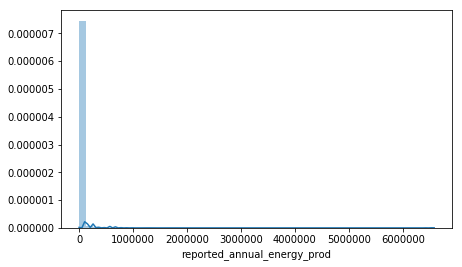

In [7]:
# Let's start out by looking at the distribution one of our target variable (reported annual energy produced, 
# which will give us a better idea of what type of models will work well.


# It's clear that this skews really positive, and is clearly not normally distributed.
plt.figure(figsize=((7,4)))
sns.distplot(df.reported_annual_energy_prod)

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


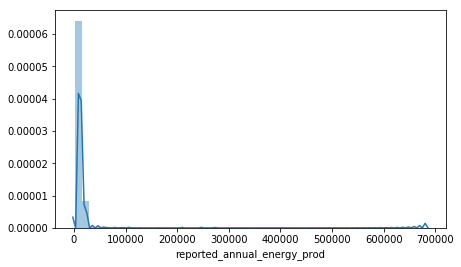

In [8]:
# We may seeing the skew from the utility scale installations, let's take those out and look at this distribution.

# Still skews really high when we only look at residential.
plt.figure(figsize=((7,4)))
sns.distplot(df.loc[df['install_type'] == 'residential'].reported_annual_energy_prod)

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


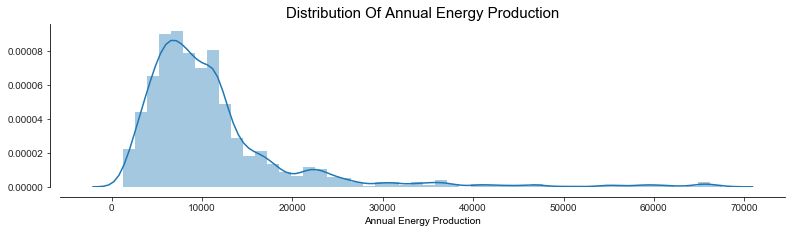

In [9]:
# let's just look at the lower values of annual energy output.

mask = df['reported_annual_energy_prod'] <= 70000
plt.figure(figsize=((13,3)))
sns.distplot(df[mask].reported_annual_energy_prod)
plt.title("Distribution Of Annual Energy Production", size=15)
plt.xlabel("Annual Energy Production")
sns.set_style("white")
sns.despine(offset=10, trim=False);

# We can see the skew a little more clearly when we limit the energy production to below 60000 kilowatt hours annually.

# Given this distribution, we may want to do a log transformation of the target, or use a generalized linear model
# like a poisson regression.

### Log Transforming Reported Annual Energy Produced

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


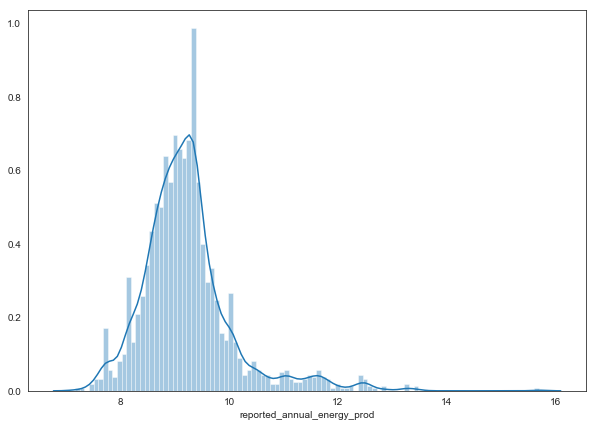

In [10]:
# Taking the log transform of reported annual energy output gives us a really nicely normally distributed target
# Would be nice to use this as the target for modeling or use a poisson regression.

plt.figure(figsize=((10,7)))
log_output = np.log(df['reported_annual_energy_prod'])
sns.distplot(log_output, bins=100)

# Outliers

There are some values for reported annual energy that are way too high, and I want to remove those from the data to improve predictive accuracy.

In [12]:
# Given how connected size and annual energy production is, I'm going to remove any data from the data set where
# efficiency is more than 6 standard deviations from the mean.  Picking a number so high just to be cautious.

# It looks like there must be some installations where efficiency is MUCH higher or lower than the rest.
df['efficiency'] = df['reported_annual_energy_prod'] / df['size_kw']

efficiency_std = df.efficiency.std()
efficiency_mean = df.efficiency.mean()

efficiency_mask = np.abs((efficiency_mean - df['efficiency'])/efficiency_std) < 6

df = df.loc[efficiency_mask, :]

# Partial Correlations

Given that size is such a strong predictor, it's interesting to see what the partial correlations between output and the other features used in the energy output models are.

In [ ]:
# Let's look at all the partial correlations

In [13]:
import numpy as np
from scipy import stats, linalg

# Taken from github
def partial_corr(C):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.
    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable
    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C.
    """
    
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
        
    return P_corr

In [14]:
df.columns

Index(['level_0', 'index', 'state', 'date_installed', 'incentive_prog_names',
       'type', 'size_kw', 'appraised', 'zipcode', 'install_type', 'installer',
       'cost_per_watt', 'cost', 'lbnl_tts', 'city', 'utility_clean', 'tech_1',
       'model1_clean', 'county', 'annual_PV_prod', 'annual_insolation',
       'rebate', 'sales_tax_cost', 'tilt1', 'tracking_type', 'azimuth1',
       'manufacturer', 'inv_man_clean', 'reported_annual_energy_prod',
       'new_constr', 'tracking', '3rdparty', 'bipv', 'efficiency'],
      dtype='object')

In [21]:
partial_corrs_df = df[['size_kw', 'azimuth1', 'tilt1', 'cost_per_watt', 'cost', 'annual_insolation', 
                       'reported_annual_energy_prod']]

In [22]:
partial_data = np.array(partial_corrs_df)

In [23]:
partial_corrs = partial_corr(partial_data)

In [24]:
def partial_corr_heat_map(df, title, size):
    partial_data = np.array(df)
    corrs = partial_corr(partial_data)
    
    # set figure size
    fig, ax = plt.subplots(figsize = size)
    
    # generate a mask for the upper triagle 
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    #plot heatmap
    ax = sns.heatmap(corrs, mask=mask, annot = True, cbar=False)
    
    #resize labels
    ax.set_xticklabels(df.columns, fontsize=12, rotation=30)
    ax.set_yticklabels(df.columns[::-1], fontsize=12, rotation=0)
    ax.set_title(title, fontsize=14)
    
    plt.show()

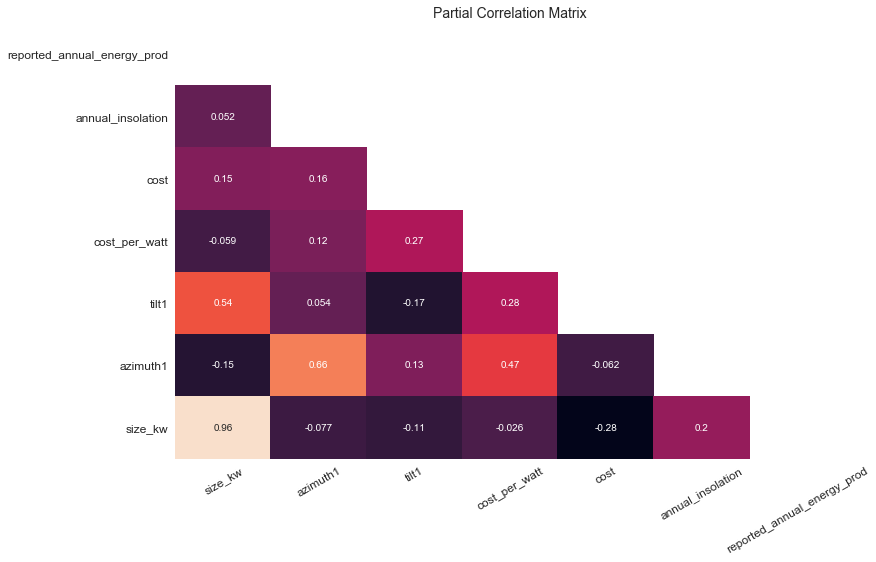

In [25]:
partial_corr_heat_map(partial_corrs_df, "Partial Correlation Matrix", (12,8))

 Surprisingly, there appears to be no more than very slight correlations between cost per watt and size. We might expect — given that we’re talking about solar energy after all — that these factors would play a large role in determining how much energy a solar panel generates and how much it will cost. In the U.S., this may not end up being the case because solar radiation is high enough that panels reach their capacity for energy production, and are unable to produce more energy even with more sun exposure. If we were to compare the performance of solar panels in the U.S. to solar panels in the arctic, we might see that radiation is more highly correlated with energy production than we see here.

# Modeling Annual Energy Output

The final model We will use for production is a random forest regression model, which has several benefits in this context. It is a non-parametric model, which means it can predict a variable that is non-normally distributed. Because there are a wide range of solar panels in the OpenPV dataset, with some utility-scale installations producing thousands of times more energy per year than small, residential panels, the data is very positively skewed. This means that in order to use a model like linear regression without having biased results, it would be necessary to log transform the data, or use a generalized linear model like a poisson regression. Random forest models also do well with categorical features, and in this case there were a few such features, including technology type and tracking type.


### Features

Based on my exploratory analysis, We settled on the following features for my model:
- 'size_kw', 
- 'install_type', 
- 'installer', 
- 'tech_1', 
- 'tracking_type'

These features are strong predictors of cost output, and are easily obtained for use in a production environment model.



In [26]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

import patsy

C:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


<a id='feature-engineering'></a>
# Feature Engineering: Adding Difference From Optimal Tilt

Optimal tilt during the winter is about latitude + 15, and during the winter it's about latitude - 15, so we can approximate optimal tilt using latitude.  To get the amount that the tilt of a solar panel is off from the optimal, we take the absolute value of the difference between the tilt and its latitude.

In [6]:
# rading in a csv that has lat/lon pairs for zipcodes.
zips = pd.read_csv("./free-zipcode-database-Primary.csv")

# joining latitude with main dataframe.
df = df.merge(zips[['Zipcode', 'Lat']], on="Zipcode")

# Calculating optimal tilt difference as absolute value of difference between the tilt and latitude.
df['optimal_tilt_diff'] = np.abs(df['tilt1'] - df['Lat'])

# Modeling Installation Cost

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


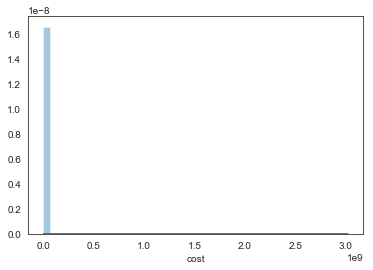

In [27]:
# Let's look at the distribution of our target variable.

# Looks very positively skewed.
plt.figure(figsize=(6,4))
sns.distplot(df_final.cost)

In [29]:
from sklearn.preprocessing import MinMaxScaler

In [30]:
df_final.shape

(1020710, 6)

In [31]:
df_final.head()

,size_kw,install_type,installer,tech_1,tracking_type,cost
0,10.560,residential,Advanced Solar & Electric,Poly,Fixed,30600.53
1,12.720,residential,Advanced Solar & Electric,Mono,Fixed,40000.00
2,5.400,residential,Advanced Solar & Electric,Mono,Fixed,22665.58
3,6.785,residential,Whole Sun Designs,NaN,NaN,17550.00
4,4.720,residential,Whole Sun Designs,NaN,NaN,12150.00


In [32]:
df_final.isna().sum()

size_kw               0
install_type          0
installer             0
tech_1           439791
tracking_type    494652
cost                  0
dtype: int64

In [33]:
# Dropping missing values
df_final.reset_index(drop=True, inplace=True)

In [34]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020710 entries, 0 to 1020709
Data columns (total 6 columns):
size_kw          1020710 non-null float64
install_type     1020710 non-null object
installer        1020710 non-null object
tech_1           580919 non-null object
tracking_type    526058 non-null object
cost             1020710 non-null float64
dtypes: float64(2), object(4)
memory usage: 46.7+ MB


## Create Dummy Variables

In [35]:
df_final = pd.get_dummies(df_final, columns = ["install_type"],prefix="install_type")

In [36]:
df_final.head()

,size_kw,installer,tech_1,tracking_type,cost,install_type_agricultural,install_type_commercial,install_type_educational,install_type_government,install_type_institutional,install_type_none,install_type_nonprofit,install_type_public,install_type_residential,install_type_utility
0,10.560,Advanced Solar & Electric,Poly,Fixed,30600.53,0,0,0,0,0,0,0,0,1,0
1,12.720,Advanced Solar & Electric,Mono,Fixed,40000.00,0,0,0,0,0,0,0,0,1,0
2,5.400,Advanced Solar & Electric,Mono,Fixed,22665.58,0,0,0,0,0,0,0,0,1,0
3,6.785,Whole Sun Designs,NaN,NaN,17550.00,0,0,0,0,0,0,0,0,1,0
4,4.720,Whole Sun Designs,NaN,NaN,12150.00,0,0,0,0,0,0,0,0,1,0


In [37]:
# Tech
df_final = pd.get_dummies(df_final, columns = ["tech_1"],prefix="tech")

In [38]:
# Tracking type
df_final = pd.get_dummies(df_final, columns = ["tracking_type"],prefix="tracking")

In [39]:
df_final.head()

,size_kw,installer,cost,install_type_agricultural,install_type_commercial,install_type_educational,install_type_government,install_type_institutional,install_type_none,install_type_nonprofit,install_type_public,install_type_residential,install_type_utility,tech_CIGS,tech_CIS,tech_CdTe,tech_Mono,tech_Mono + a-Si,tech_Poly,tech_Thin Film,tech_a-Si,tech_a-Si + Micro-c,tech_crystalline,tech_multiple,tracking_Dual-Axis,tracking_Fixed,tracking_Mixed,tracking_Single-Axis
0,10.560,Advanced Solar & Electric,30600.53,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,12.720,Advanced Solar & Electric,40000.00,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,5.400,Advanced Solar & Electric,22665.58,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,6.785,Whole Sun Designs,17550.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4.720,Whole Sun Designs,12150.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
df_final.shape

(1020710, 28)

In [41]:
y = df_final.iloc[:, 2].values

In [42]:
del(df_final['cost'])
del(df_final['installer'])

In [43]:
df_final.astype(int)

,size_kw,install_type_agricultural,install_type_commercial,install_type_educational,install_type_government,install_type_institutional,install_type_none,install_type_nonprofit,install_type_public,install_type_residential,install_type_utility,tech_CIGS,tech_CIS,tech_CdTe,tech_Mono,tech_Mono + a-Si,tech_Poly,tech_Thin Film,tech_a-Si,tech_a-Si + Micro-c,tech_crystalline,tech_multiple,tracking_Dual-Axis,tracking_Fixed,tracking_Mixed,tracking_Single-Axis
0,10,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,12,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,5,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,12,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
X = df_final.values

<a id='random-forest'></a>
## Training Random Forest Model

In [113]:
rand_forest = RandomForestRegressor(n_estimators=150)

# Creating gridsearch to find optimal parameters.
params = {
    'max_depth': [65,70,75,80,90],
    'max_features': [10,11,12]
}

gs_rf = GridSearchCV(rand_forest, params, cv=8, verbose=1)

In [31]:
# Splitting the dataset into the Training set and Test set

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=25)

In [116]:
gs_rf.fit(X_train, y_train)

Fitting 8 folds for each of 15 candidates, totalling 120 fits


//anaconda/lib/python2.7/site-packages/sklearn/model_selection/_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 194.6min finished
//anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_estimator.fit(X, y, **self.fit_params)


GridSearchCV(cv=8, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [10, 11, 12], 'max_depth': [65, 70, 75, 80, 90]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [117]:
gs_rf.best_score_

0.91866230060217668

In [118]:
gs_rf.score(X_test, y_test)

0.9487661780415132

In [119]:
gs_rf.best_params_

{'max_depth': 65, 'max_features': 11}

In [ ]:
# Let's try some different params, since max depth was the lowest level we gave it.

In [120]:
params = {
    'max_depth': [60,62,65],
    'max_features': [10,11,12]
}

gs_rf = GridSearchCV(rand_forest, params, cv=8, verbose=1)

In [121]:
gs_rf.fit(X_train, y_train)

Fitting 8 folds for each of 9 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 120.9min finished


GridSearchCV(cv=8, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [10, 11, 12], 'max_depth': [60, 62, 65]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [122]:
gs_rf.best_params_

{'max_depth': 62, 'max_features': 12}

In [123]:
gs_rf.best_score_

0.91995480462950152

### Score for RF model:

In [32]:
rf = RandomForestRegressor(n_estimators=150, max_depth=62, max_features=12)

%time rf.fit(X_train, y_train)

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


CPU times: user 2min 4s, sys: 2.31 s, total: 2min 6s
Wall time: 2min 11s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=62,
           max_features=12, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [34]:
rf.score(X_test, y_test)

0.97305201121015517

In [ ]:
# saving this model.
import pickle

filename = 'finalized_rf_model.sav'
pickle.dump(rf, open(filename, 'wb'))

In [19]:
import pickle
from pickle import load

In [20]:
filename = 'finalized_rf_model.sav'
rf = pickle.load(open(filename, 'rb'))

### Results

Using the random forest model, I achieved an R² value of .973 on validation data. The validation data were the same values used to generate the baseline score, so the comparison is completely like-to-like. In terms of annual savings, the median error drops from the baseline of $60.00 to +/- approximately $15.00 in predicted savings on energy.

Figure 7. Feature importances of the random forest model
Feature importances of a random forest model are a clear and easy way to interpret how much different variables contribute to predictions. More specifically, in Figure. they show the percent increase to mean squared error were a variable to be excluded from the model. We see that size contributes the most to predicting energy production, with an 87% importance. Direct and diffuse irradiance also play a role. These findings indicate that while it’s most important to build as large an installation as possible, building in places with high direct irradiance and low diffuse irradiance will help to produce more energy. The last feature here is optimal tilt difference, which plays a comparatively small role in determining energy output. The more off a solar panel is from its optimal tilt, the less energy it will generate. Other factors in the model have a negligible importance.


In [38]:
rf_pred = rf.predict(X_test)

In [39]:
mse_rf = mean_squared_error(nrel_y_true, rf_pred)

# Root mean squared error dollars
mse_rf ** 0.5 * .1024

2647.7966620365455

In [40]:
# Calculating median dollars estimate is off in annual returns on solar energy generated.

abs_residuals = np.abs(np.array(nrel_y_true) - np.array(rf_pred))

# avg us rate per kilowatt hour is $.1024
residuals_dollars = abs_residuals * .1024

np.median(residuals_dollars)

15.446016000000016

### Looking For Bias

There may be bias in this model, particularly because one feature dominates the predictions so heavily, and because the target variable is so positively skewed.  We can plot the residuals to investigate this.


In [28]:
# Calculating predicted values for whole X
rf_pred = rf.predict(X)
Splitting the dataset into the Training set and Test set
# Getting y true values
y_vals = np.array([val[0] for val in y.values])

# calculating residuals
rf_residuals = rf_pred - y_vals